In [1]:
import os
import cv2
from sklearn.cluster import KMeans
import time
import numpy as np
import copy
from sklearn.preprocessing import normalize
import math
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from gensim.models import LdaModel

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# ----------------FUNCTIONS-------------------- #

# to overlay descriptors on image (colored by topic)
def prediction(model, img, img_bow, kp, kp_colors=None, show=True):
    img_copy=img.copy()
    for i in range(len(kp)):
        color = (255,0,0) if kp_colors is None else kp_colors[i]
        img = cv2.drawKeypoints(img, [kp[i]], 
                                img_copy, color=(color),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    if show:
        plt.imshow(img_copy)
        plt.show()
    else:
        return img_copy

# return index for a certain image name
def img_name2index(name, file_names):
    for i in range(len(file_names)):
        if name in file_names[i]:
            return i
    print("Not found..")
    return None
 
# initial utility to show overlayed keypoints on img, no topic coloring
def viewImgsWithKp(img, kp):
    print_img = copy.deepcopy(img)
    cv2.drawKeypoints(print_img,kp,print_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(print_img)

# get descriptors for an image using MSER, ORB keypoint generation
def siftImg(img):
    sift = cv2.xfeatures2d.SIFT_create()
    #0 - get grayscale
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #1 − Detect diff sources, describe with SIFT
    orb = cv2.ORB_create()
    mser = cv2.MSER_create()
    kp = mser.detect(grayImg)
    kp += orb.detect(grayImg)
    kp,des=sift.compute(grayImg, kp)
    return kp, des

# apply siftImg to multiple images
def siftImgs(imgs):
    imgs_kp = []
    imgs_des = []
    for img in imgs:
        sift_kp, sift_des = siftImg(img)
        imgs_des.append(sift_des)
        imgs_kp.append(sift_kp)
    return imgs_des, imgs_kp

# construct bow for a certain image given a clustering result
def get_bow(img_des, kmeans_res, verbose=False):
    img_bow_temp = np.zeros(kmeans_res.n_clusters)
    img_des_idx = kmeans_res.predict(np.array(img_des,dtype='double'))
    for idx in img_des_idx:
        img_bow_temp[idx] += 1
    img_bow = []
    for idx, freq in enumerate(img_bow_temp):
        if freq != 0:
            img_bow.append(tuple((idx,freq)))
    if verbose: print(img_bow)
    return img_bow

# create dictionary with descriptor as key and its index in original list as value
def create_des2idx_dict(des):
    des_dict = {}
    for i,descriptor in enumerate(des):
        des_dict[descriptor.tobytes()] = i
    return des_dict

# get index for a particular descriptor
def des2idx(descriptor,des_dict):
    return des_dict.get(descriptor.tobytes(), None) # None means descriptor not in training descriptors

# given an lda model, get the most probable topic for a descriptor
def des2topic(descriptor,kmeans_res,word2topic=None,model=None):
    keyword_idx = kmeans_res.predict(np.array(descriptor.reshape(1,-1),dtype='double'))[0]
    if word2topic is not None: 
        topic_des = word2topic[keyword_idx]
    else:
        topic_des = np.argsort([el[1] for el in model.get_term_topics(keyword_idx, minimum_probability=0)])[-1]  
    return topic_des

# create structure which for each descriptor gives its most probable topic
def get_word2topic(model, word_ids):
    word2topic = {}
    model_word_to_topic = model.get_topics()
    for i in word_ids:
        word2topic[i] = np.argsort(model_word_to_topic[:,i])[-1]
    return word2topic

# -------------------------------------------- #

In [3]:
colors = {
    0:(249,112,42), # orangey red
    1:(18,159,244), # cyan
    2:(248,73,242), # magenta
    3:(217,0,95),   # dark red
    4:(196,196,240),# light blue-grey
    5:(95,241,183), # water green
    6:(57,43,133),  # dark blue
    7:(136,20,116), # almost violet
    8:(157,218,45), # green pastel
    9:(130,91,24),  # brown
    10:(251,53,18), # highlighter red
    11:(150,47,225),# purple
    12:(0,0,0),     # black
    13:(255,255,150)# whiteish yellow
}

# PREPARING FOR VOCABULARY CREATION

In [4]:
# compute all SIFT descriptors
imgs_des = []
imgs = []
file_names = []
imgs_kp = []
img_folder = os.getcwd()+"\images\\"

for file_name in os.listdir(img_folder):
    if "GT" not in file_name:
        imgs.append(cv2.imread(img_folder+file_name))
        file_names.append(file_name)
        
# split into train and test
test_size = len(imgs)//5
order_mix = np.random.permutation(len(imgs))
file_names = np.array(file_names)[order_mix]
imgs = np.array(imgs)[order_mix]

train_imgs = imgs[:len(imgs) - test_size]
train_file_names = file_names[:len(file_names) - test_size]
test_imgs = imgs[len(imgs) - test_size:]
test_file_names = file_names[len(imgs) - test_size:]
print(f"Train size: {len(train_imgs)} - Test size: {len(test_imgs)}")

# get descriptor for all training imgs
start = time.time()
imgs_des, imgs_kp = siftImgs(train_imgs)
des = [ image_descriptor for image_descriptors in imgs_des for image_descriptor in image_descriptors ]
des_dict = create_des2idx_dict(des)
print(f"{len(des)} SIFT descriptors of {len(train_imgs)} images computed in {round(time.time()-start,3)} seconds")

Train size: 192 - Test size: 47
118447 SIFT descriptors of 192 images computed in 37.191 seconds


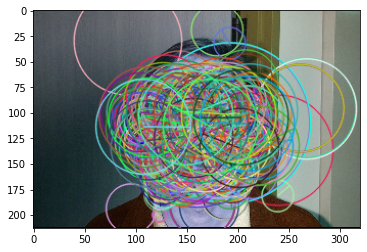

In [5]:
# quick test
file_to_search = '6'
viewImgsWithKp(train_imgs[img_name2index(file_to_search,train_file_names)],imgs_kp[img_name2index(file_to_search,train_file_names)])

# VOCABULARY CREATION ( DEFINE BOW ) 

In [6]:
# compute KMEANS
start = time.time()
ndim = 500
kmeans_res = KMeans(n_clusters=ndim, verbose=1, n_jobs=-2).fit(des)
print(kmeans_res.labels_)
print(f"KMeans with {ndim} clusters computed in {round(time.time()-start,3)} seconds")

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 8478672350.0
Iteration 1, inertia 6542902849.797733
Iteration 2, inertia 6393511051.459358
Iteration 3, inertia 6334073540.650966
Iteration 4, inertia 6303230943.820645
Iteration 5, inertia 6282077537.774994
Iteration 6, inertia 6265753354.238373
Iteration 7, inertia 6252986477.369277
Iteration 8, inertia 6242773740.184365
Iteration 9, inertia 6233971915.211887
Iteration 10, inertia 6226908303.119124
Iteration 11, inertia 6221295171.462407
Iteration 12, inertia 6216805398.482829
Iteration 13, inertia 6212828201.3379
Iteration 14, inertia 6209310418.862648
Iteration 15, inertia 6206054681.87609
Iteration 16, inertia 6203296236.593823
Iteration 17, inertia 6200733238.894145
Iteration 18, inertia 6198505974.65228
Iteration 19, inertia 6196555741.110359
Iteration 20, inertia 6194724939.72488
Iteration 21, inertia 6193180136.891733
Iteration 22, inertia 6191605489.664121
Iteration 23, inertia 6190257472.25487
Iteration 24, inertia 6189088924.1145

Iteration 108, inertia 6178719249.57574
Iteration 109, inertia 6178709255.578344
Iteration 110, inertia 6178698133.191862
Iteration 111, inertia 6178689827.890175
Iteration 112, inertia 6178671993.91827
Iteration 113, inertia 6178652286.524569
Iteration 114, inertia 6178642383.320041
Iteration 115, inertia 6178632067.459714
Iteration 116, inertia 6178625678.791966
Iteration 117, inertia 6178616976.83936
Iteration 118, inertia 6178607618.331651
Iteration 119, inertia 6178600329.912611
Iteration 120, inertia 6178591622.955489
Iteration 121, inertia 6178586765.19787
Iteration 122, inertia 6178581217.360046
Iteration 123, inertia 6178576083.88094
Iteration 124, inertia 6178550236.386769
Iteration 125, inertia 6178446061.48457
Iteration 126, inertia 6178363460.743365
Iteration 127, inertia 6178276032.010389
Iteration 128, inertia 6178190972.175369
Iteration 129, inertia 6178163518.5224
Iteration 130, inertia 6178110931.029123
Iteration 131, inertia 6178036590.020261
Iteration 132, inertia 6

Iteration 48, inertia 6178813256.747497
Iteration 49, inertia 6178768258.075075
Iteration 50, inertia 6178719089.593739
Iteration 51, inertia 6178660758.191789
Iteration 52, inertia 6178611890.998823
Iteration 53, inertia 6178540807.296814
Iteration 54, inertia 6178483978.014725
Iteration 55, inertia 6178429978.524261
Iteration 56, inertia 6178376039.965917
Iteration 57, inertia 6178324566.098982
Iteration 58, inertia 6178285831.653451
Iteration 59, inertia 6178258595.545454
Iteration 60, inertia 6178227092.823415
Iteration 61, inertia 6178200962.128481
Iteration 62, inertia 6178176915.650617
Iteration 63, inertia 6178152612.134777
Iteration 64, inertia 6178135865.267894
Iteration 65, inertia 6178109476.2033415
Iteration 66, inertia 6178075947.990701
Iteration 67, inertia 6178049092.269983
Iteration 68, inertia 6178029393.798156
Iteration 69, inertia 6178004581.082238
Iteration 70, inertia 6177983226.102537
Iteration 71, inertia 6177971004.528103
Iteration 72, inertia 6177953641.654642

Iteration 36, inertia 6175596286.589855
Iteration 37, inertia 6174959897.110608
Iteration 38, inertia 6174445018.474953
Iteration 39, inertia 6173945648.804854
Iteration 40, inertia 6173419369.875648
Iteration 41, inertia 6172946861.213051
Iteration 42, inertia 6172525956.631423
Iteration 43, inertia 6172117383.424268
Iteration 44, inertia 6171679125.633351
Iteration 45, inertia 6171293582.244621
Iteration 46, inertia 6170835401.802337
Iteration 47, inertia 6170467542.886264
Iteration 48, inertia 6170147755.854834
Iteration 49, inertia 6169886132.845421
Iteration 50, inertia 6169678539.248259
Iteration 51, inertia 6169504479.351447
Iteration 52, inertia 6169329603.242501
Iteration 53, inertia 6169188839.168659
Iteration 54, inertia 6169071125.240479
Iteration 55, inertia 6168962203.854136
Iteration 56, inertia 6168856676.361331
Iteration 57, inertia 6168714727.581406
Iteration 58, inertia 6168509027.676578
Iteration 59, inertia 6168290250.865009
Iteration 60, inertia 6168085449.369722


Iteration 8, inertia 6245162070.516367
Iteration 9, inertia 6237421270.106415
Iteration 10, inertia 6231075851.032295
Iteration 11, inertia 6225977855.152404
Iteration 12, inertia 6221472091.373518
Iteration 13, inertia 6217238876.331877
Iteration 14, inertia 6213326939.125898
Iteration 15, inertia 6209668680.294615
Iteration 16, inertia 6206500565.619205
Iteration 17, inertia 6203930969.300494
Iteration 18, inertia 6201607440.466346
Iteration 19, inertia 6199719792.135367
Iteration 20, inertia 6198097457.217884
Iteration 21, inertia 6196657027.029769
Iteration 22, inertia 6195379049.231537
Iteration 23, inertia 6194303720.221279
Iteration 24, inertia 6193453088.667743
Iteration 25, inertia 6192638381.080442
Iteration 26, inertia 6191883617.145073
Iteration 27, inertia 6191258535.103634
Iteration 28, inertia 6190646310.322268
Iteration 29, inertia 6190059060.428762
Iteration 30, inertia 6189562423.599061
Iteration 31, inertia 6189140348.165115
Iteration 32, inertia 6188753185.50739
Ite

Iteration 211, inertia 6175507722.223557
Iteration 212, inertia 6175498015.727189
Iteration 213, inertia 6175490716.0314665
Iteration 214, inertia 6175484573.898831
Iteration 215, inertia 6175477691.197771
Iteration 216, inertia 6175473054.931841
Iteration 217, inertia 6175468201.017721
Iteration 218, inertia 6175461807.676725
Iteration 219, inertia 6175456070.646179
Iteration 220, inertia 6175449626.181295
Iteration 221, inertia 6175447159.985621
Iteration 222, inertia 6175444236.068615
Iteration 223, inertia 6175442711.719434
Iteration 224, inertia 6175440788.67492
Iteration 225, inertia 6175439250.4499655
Iteration 226, inertia 6175432513.241381
Iteration 227, inertia 6175421677.461117
Iteration 228, inertia 6175417440.754527
Iteration 229, inertia 6175415757.779071
Iteration 230, inertia 6175414526.236799
Iteration 231, inertia 6175412616.814451
Iteration 232, inertia 6175410767.180513
Iteration 233, inertia 6175409778.8437
Iteration 234, inertia 6175409181.616929
Iteration 235, in

Iteration 71, inertia 6175151479.744981
Iteration 72, inertia 6175094715.766048
Iteration 73, inertia 6175041437.103435
Iteration 74, inertia 6174996414.911252
Iteration 75, inertia 6174945008.201949
Iteration 76, inertia 6174847138.629101
Iteration 77, inertia 6174783053.988251
Iteration 78, inertia 6174746589.514261
Iteration 79, inertia 6174707037.8152895
Iteration 80, inertia 6174668189.938454
Iteration 81, inertia 6174631542.547741
Iteration 82, inertia 6174596067.595462
Iteration 83, inertia 6174470433.882214
Iteration 84, inertia 6174254854.705851
Iteration 85, inertia 6174199098.754903
Iteration 86, inertia 6174174420.618179
Iteration 87, inertia 6174149102.121443
Iteration 88, inertia 6174107985.010112
Iteration 89, inertia 6174073623.333097
Iteration 90, inertia 6174011436.279085
Iteration 91, inertia 6173977959.794169
Iteration 92, inertia 6173952769.8913765
Iteration 93, inertia 6173925218.387321
Iteration 94, inertia 6173901087.653339
Iteration 95, inertia 6173877631.0321


In [7]:
# create bow as tuple of WORD - FREQ for every img
def get_bow(img_des, kmeans_res, verbose=False):
    img_bow_temp = np.zeros(kmeans_res.n_clusters)
    img_des_idx = kmeans_res.predict(np.array(img_des,dtype='double'))
    for idx in img_des_idx:
        img_bow_temp[idx] += 1
    img_bow = [] # process, we need a tuple!
    for idx, freq in enumerate(img_bow_temp):
        if freq != 0:
            img_bow.append(tuple((idx,freq)))
    if verbose: print(img_bow)
    return img_bow
bow = np.array([get_bow(img_des,kmeans_res) for img_des in imgs_des])

# create hyperdumb dict (needed to score coherence)
id2word = {}
for i in range(kmeans_res.n_clusters):
    id2word[i] = i

#  CHOOSING LDA MODEL

In [8]:
from gensim.models.coherencemodel import CoherenceModel
ntopic = 8 # minimum since there are at least 8 different types of images
n_topics =[i for i in range(ntopic, ntopic*3)]
model_grid_ntopics = []
for n in n_topics:
    lda = LdaModel(bow, num_topics=n, id2word=id2word, per_word_topics=True ,minimum_probability=0, random_state=123)
    model_grid_ntopics.append((n,CoherenceModel(model=lda, corpus=bow, coherence='u_mass').get_coherence()))

Best n_topics: 9 - Coherence: -0.9346795793805265


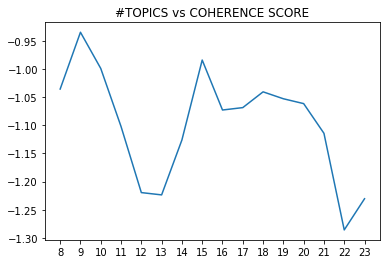

In [9]:
coherence_scores = [m[1] for m in model_grid_ntopics]
plt.xticks(range(len(n_topics)),n_topics)
plt.title("#TOPICS vs COHERENCE SCORE")
plt.plot(coherence_scores)
ntopic = n_topics[np.argsort(coherence_scores)[-1]]
print("Best n_topics:",ntopic, "- Coherence:",coherence_scores[np.argsort(coherence_scores)[-1]])

# BUILD MODEL

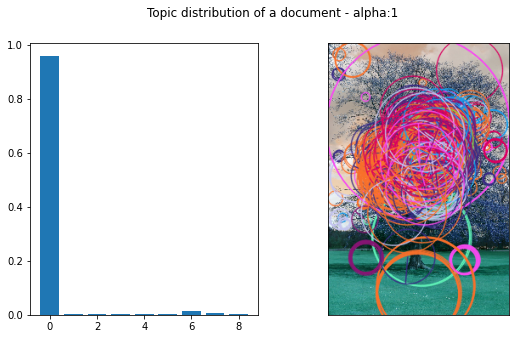

In [24]:
# create lda model (GENSIM for the win!)
chosen_alpha = 1
lda = LdaModel(bow, num_topics=ntopic, 
               alpha=chosen_alpha, 
               id2word=id2word, 
               per_word_topics=True, 
               minimum_probability=0, 
               random_state=123)

idx = 0
fig,axs = plt.subplots(1,2,figsize=(9,5))
fig.suptitle(f"Topic distribution of a document - alpha:{chosen_alpha}")
axs[0].bar([el[0] for el in lda.get_document_topics(bow[idx])],height=[el[1] for el in lda.get_document_topics(bow[idx])])
kp_colors = [colors[des2topic(imgs_des[idx][i], kmeans_res, model=lda)] for i in range(len(imgs_des[idx]))]
axs[1].imshow(prediction(lda, train_imgs[idx], bow[idx],imgs_kp[idx],kp_colors=kp_colors, show=False))
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

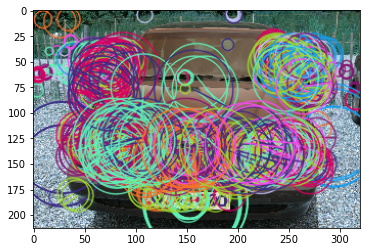

In [11]:
# time to test: get bow description for test imgs and a dictionary to get top topic per descriptor
test_imgs_des, test_imgs_kp = siftImgs(test_imgs)
test_bow = np.array([get_bow(img_des,kmeans_res) for img_des in test_imgs_des])
word2topic = get_word2topic(lda,[i for i in range(kmeans_res.n_clusters)])

# quick test
kp_colors = [colors[des2topic(test_imgs_des[idx][i], kmeans_res, model=lda)] for i in range(len(test_imgs_des[idx]))]
prediction(lda, test_imgs[idx], test_bow[idx],test_imgs_kp[idx],kp_colors=kp_colors)

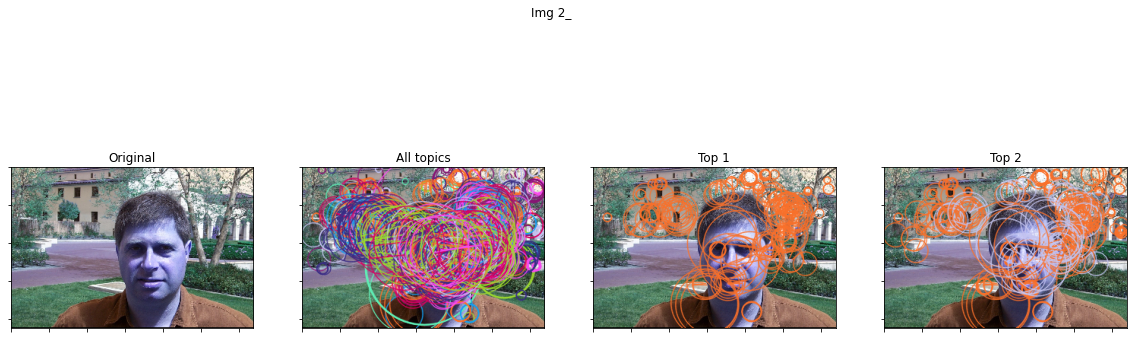

'6_2_s.bmp'

In [12]:
# get overlay on chosen img
# original | all topics overlay | most probable topic overlay | 2 most probable topics overlay

img_file_name = '2_'
idx = img_name2index( img_file_name , test_file_names)

fig,axs=plt.subplots(1,4, figsize=(20,20))
fig.suptitle(f"Img {img_file_name}")
axs[0].title.set_text("Original")
axs[0].imshow(test_imgs[idx])

lda_doc_top = lda.get_document_topics(test_bow[idx])

# get most relevant kp
top_topic = np.argsort(np.array([el[1] for el in lda_doc_top]))[-1]
top_topic_kp = []
kp_colors = []
for i in range(len(test_imgs_des[idx])):
    kp_topic = des2topic(test_imgs_des[idx][i],kmeans_res,model=lda)
    if kp_topic == top_topic:
        top_topic_kp.append(test_imgs_kp[idx][i])
        kp_colors.append(colors[top_topic])
top_topic_kp = np.array(top_topic_kp)
# print("Top topic:",top_topic)

axs[1].title.set_text("All topics")
axs[1].imshow(prediction(lda, test_imgs[idx], test_bow[idx],test_imgs_kp[idx], kp_colors=[colors[des2topic(test_imgs_des[idx][i], kmeans_res, model=lda)] for i in range(len(test_imgs_des[idx]))], show=False))


axs[2].title.set_text("Top 1")
axs[2].imshow(prediction(lda, test_imgs[idx], test_bow[idx],top_topic_kp,kp_colors, show=False))

lda_doc_top = lda.get_document_topics(test_bow[idx])
document_top_topics = np.argsort(np.array([el[1] for el in lda.get_document_topics(test_bow[idx])]))[-2:]
top_topic_kp = []
for i in range(len(test_imgs_des[idx])):
    kp_topic = des2topic(test_imgs_des[idx][i],kmeans_res,model=lda)
    if kp_topic in document_top_topics:
        top_topic_kp.append(test_imgs_kp[idx][i])
        kp_colors.append(colors[kp_topic])
top_topic_kp = np.array(top_topic_kp)
# print("Top topic:",document_top_topics)

axs[3].title.set_text("Top 2")
axs[3].imshow(prediction(lda, test_imgs[idx], test_bow[idx],top_topic_kp,kp_colors, show=False))
fig.subplots_adjust(top=1.5)
for i in range(4):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
plt.show()
test_file_names[idx]

# SEGMENTATION TESTS (TRY AND TUNE THE PARAMETERS)

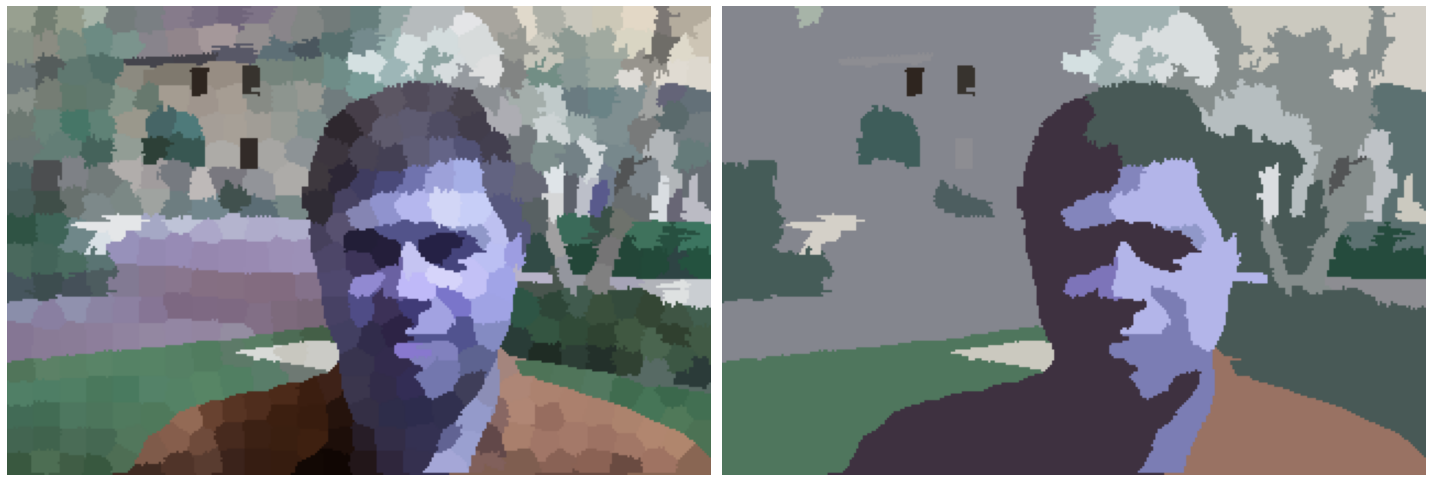

In [13]:
# segment a chosen image

from skimage import data, segmentation, color
from skimage.future import graph


img = test_imgs[idx]

labels1 = segmentation.slic(img, compactness=30, n_segments=500, # try to play with compactness
                            start_label=1)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

# iterate ncut to get less regions while trying to keep coherent the resulting regions
ncut_iter = 4
labels2 = labels1
for i in range(ncut_iter):
    g = graph.rag_mean_color(img, labels2, mode='similarity')
    labels2 = graph.cut_normalized(labels2, g)
    out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20,20))

ax[0].imshow(out1.astype('uint8'))
ax[1].imshow(out2.astype('uint8'))


for a in ax:
    a.axis('off')

plt.tight_layout()

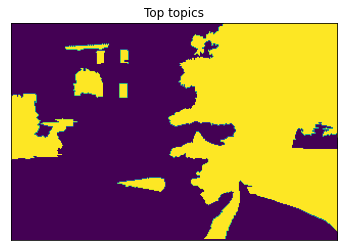

In [14]:
# topic segmentation based on coloring only top topics
# init regions topic perc (relevant topic - rest of topics)
labels = labels2
unique_labels, counts = np.unique(labels, return_counts=True)
prob_background = unique_labels[np.argmax(counts)] # we don't want to print this, too large

relevant_topics = document_top_topics
test_img_idx = idx
img_regions_topics = {}
for label in np.unique(labels):
    img_regions_topics[label] = [0, 0]
test_imgs_des_topic = []
for i in range(len(test_imgs_des[test_img_idx])):
    test_imgs_des_topic.append(des2topic(test_imgs_des[test_img_idx][i],kmeans_res, model=lda))

for i in range(len(test_imgs_des_topic)):
    kp_xy = test_imgs_kp[test_img_idx][i].pt
    kp_xy = (round(kp_xy[1]), round(kp_xy[0])) # x,y but since it will be given as row, column of matrix..
    if test_imgs_des_topic[i]  in relevant_topics:
        img_regions_topics[labels[kp_xy]][0] += 1
    img_regions_topics[labels[kp_xy]][1] += 1
    
# understand which labels we want to print, then print them
relevant_labels = []        
for k,v in img_regions_topics.items():
    normalize = v[1]
    normalize = math.inf if normalize == 0 else normalize
    v = [v[0] / normalize, v[1] / normalize]
    img_regions_topics[k] = v
    if v[0] > 0.2:
        relevant_labels.append(k)
        
region_label = 1
img_regions = np.zeros(labels.shape)
for r in range(len(labels)):
    for c in range(len(labels[0])):
        if labels[r][c] in relevant_labels and labels[r][c] != prob_background:
#             print(f"r:{r} - c:{c}")
            img_regions[r][c] = region_label
plt.xticks([])
plt.yticks([])
plt.title("Top topics")
plt.imshow(img_regions)

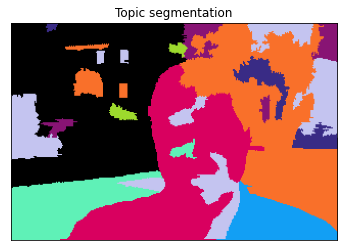

In [15]:
# topic segmentation over all regions
# create topic probability distribution for each region
test_img_idx = idx
img_regions_all_topics = {}
for label in np.unique(labels):
    img_regions_all_topics[label] = np.zeros(ntopic)
test_imgs_des_topic = []
for i in range(len(test_imgs_des[test_img_idx])):
    test_imgs_des_topic.append(des2topic(test_imgs_des[test_img_idx][i],kmeans_res, model=lda))

for i in range(len(test_imgs_des_topic)):
    kp_xy = test_imgs_kp[test_img_idx][i].pt
    kp_xy = (round(kp_xy[1]), round(kp_xy[0])) # x,y but since it will be given as row, column of matrix..
    img_regions_all_topics[labels[kp_xy]][test_imgs_des_topic[i]] += 1

# create colored img based on most probable topic of the region, plot it
img_regions = []
for r in range(len(labels)):
    img_regions_row = []
    for c in range(len(labels[0])):
        if labels[r][c] == prob_background:
            img_regions_row.append([0,0,0])
        else:
            img_regions_row.append(list(colors[np.argmax(img_regions_all_topics[labels[r][c]])]))
 
    img_regions.append(img_regions_row)
plt.xticks([])
plt.yticks([])
plt.title("Topic segmentation")
plt.imshow(img_regions)

# CLUSTERING USING DOC TOPIC DISTRIBUTION

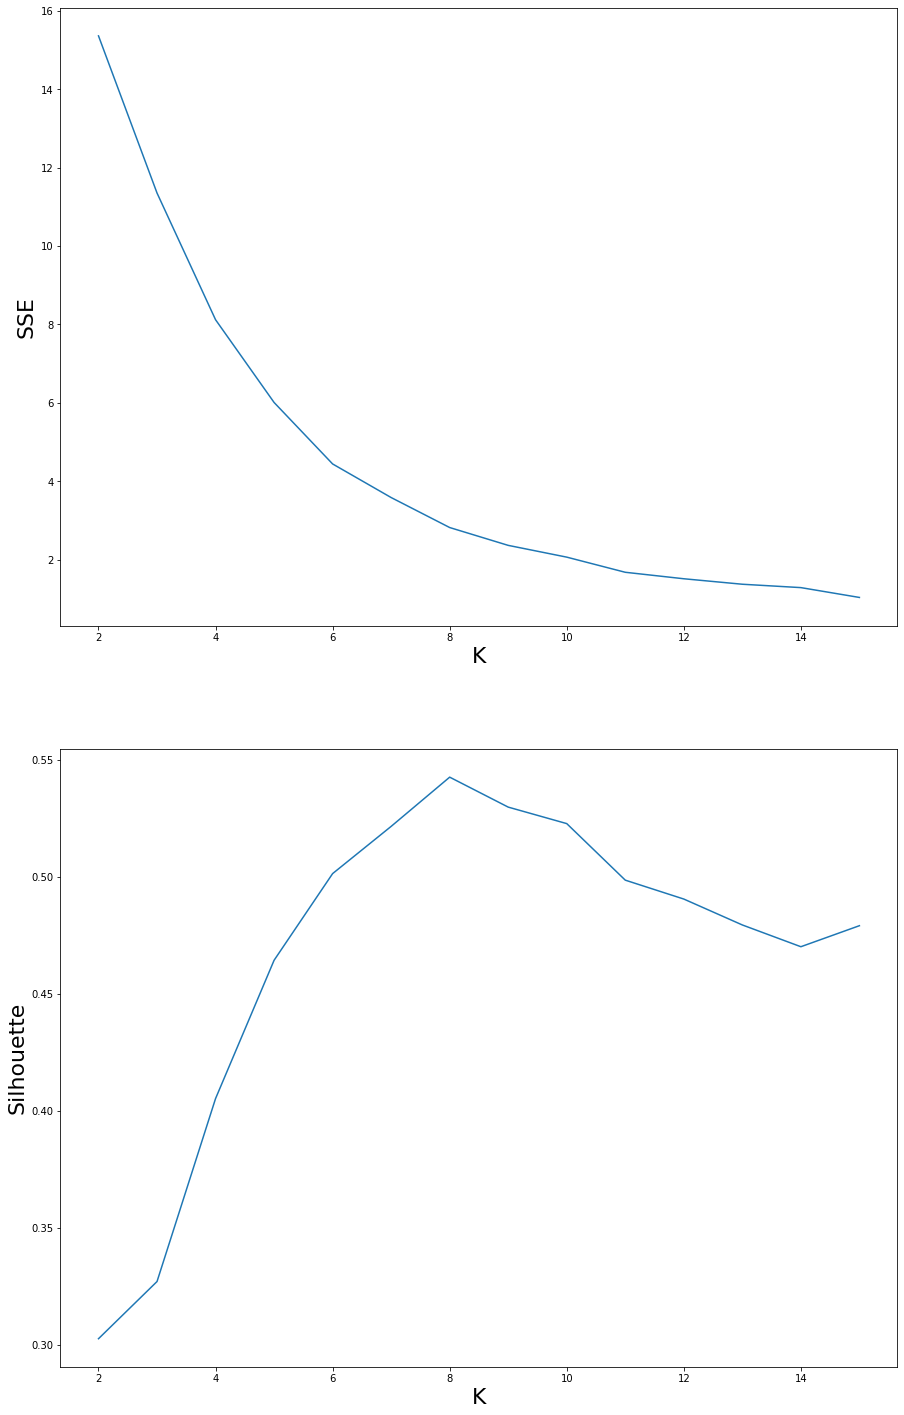

In [16]:
# construct topic percentages for test images
test_imgs_topic_perc = []
for i in range(len(test_bow)):
    test_imgs_topic_perc.append([el[1] for el in lda.get_document_topics(test_bow[i])])
test_imgs_topic_perc = np.array(test_imgs_topic_perc)

# run kmeans over topic space of test
sse_list = list()
sil_list = list()
max_k = 15
for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Iterating over possible K values"):
    kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans_iter.fit(test_imgs_topic_perc)
    
    sil_list.append(silhouette_score(test_imgs_topic_perc, kmeans_iter.labels_))
    sse = kmeans_iter.inertia_
    sse_list.append(sse)
# plot indicators
fig, axs = plt.subplots(2,1,figsize=(15,25))
axs[0].plot(range(2, len(sse_list) + 2), sse_list)
axs[0].set_ylabel('SSE', fontsize=22)
axs[0].set_xlabel('K', fontsize=22)
axs[0].tick_params(axis='both', which='major', labelsize=10)

axs[1].plot(range(2, len(sil_list) + 2), sil_list)
axs[1].set_ylabel('Silhouette', fontsize=22)
axs[1].set_xlabel('K', fontsize=22)
axs[1].tick_params(axis='both', which='major', labelsize=10)

In [17]:
# elbow rule for sse - highest silhouette possible
k = 6
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(test_imgs_topic_perc)
print("SSE:",sse_list[k-2]," - SILHOUETTE:",sil_list[k-2])

SSE: 4.43921422958374  - SILHOUETTE: 0.5013786


In [18]:
# divide the test set in the various clusters
test_clustered_files = {}
for i in range(len(kmeans.labels_)):
    label = kmeans.labels_[i]
    if label not in test_clustered_files:
        test_clustered_files[label] = [test_file_names[i]]
    else:
        test_clustered_files[label].append(test_file_names[i])
test_clustered_files

{4: ['7_20_s.bmp',
  '7_27_s.bmp',
  '5_3_s.bmp',
  '3_26_s.bmp',
  '3_29_s.bmp',
  '1_3_s.bmp',
  '4_13_s.bmp',
  '2_3_s.bmp',
  '7_3_s.bmp',
  '6_23_s.bmp',
  '3_8_s.bmp',
  '1_4_s.bmp',
  '3_13_s.bmp'],
 0: ['6_2_s.bmp',
  '2_12_s.bmp',
  '1_2_s.bmp',
  '8_9_s.bmp',
  '8_28_s.bmp',
  '5_9_s.bmp',
  '8_24_s.bmp',
  '3_5_s.bmp',
  '2_2_s.bmp',
  '8_13_s.bmp'],
 2: ['4_4_s.bmp',
  '4_17_s.bmp',
  '4_23_s.bmp',
  '4_9_s.bmp',
  '4_28_s.bmp',
  '4_24_s.bmp'],
 3: ['1_16_s.bmp', '7_2_s.bmp', '5_15_s.bmp', '5_11_s.bmp', '5_16_s.bmp'],
 1: ['2_25_s.bmp',
  '5_19_s.bmp',
  '5_13_s.bmp',
  '1_13_s.bmp',
  '6_18_s.bmp',
  '2_21_s.bmp',
  '2_20_s.bmp',
  '5_29_s.bmp',
  '5_20_s.bmp',
  '6_13_s.bmp'],
 5: ['6_25_s.bmp', '6_15_s.bmp', '6_6_s.bmp']}

### FINALLY PRINTING CLUSTER BY TOPIC (PLAY WITH THE topicnum NUMBER)

Cluster n.2 out of 6


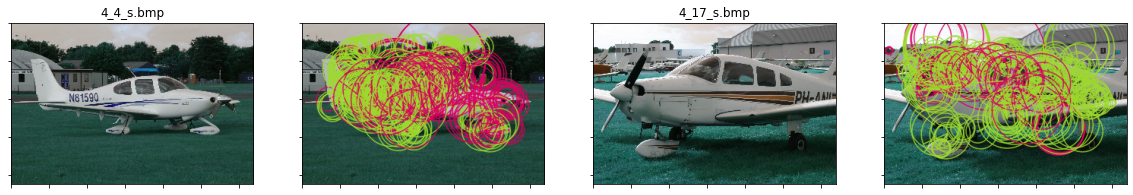

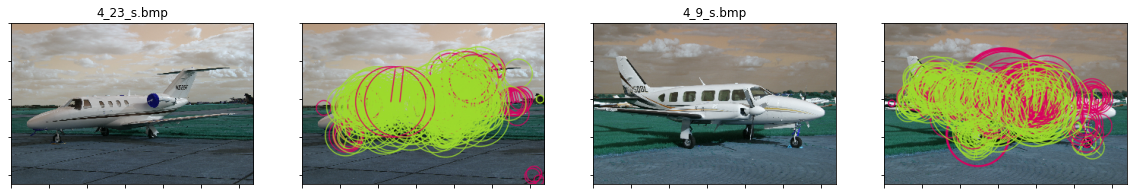

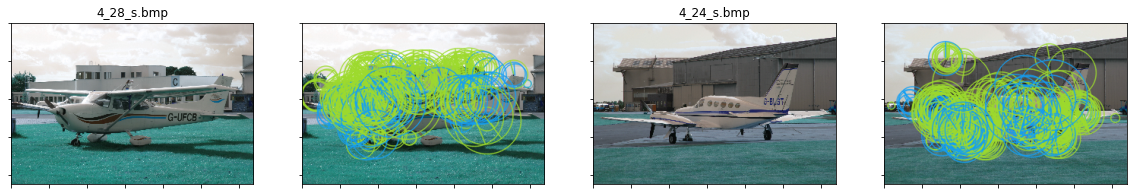

In [19]:
topicnum = 2
print(f"Cluster n.{topicnum} out of {kmeans.n_clusters}")
print_helper = 0
for i in range(len(test_clustered_files[topicnum])):
    if print_helper==0: fig,axs=plt.subplots(1,4, figsize=(20,20))
    img_idx = img_name2index(test_clustered_files[topicnum][i],test_file_names)
    print_this = test_imgs[img_idx]
    axs[print_helper].imshow(print_this)
    axs[print_helper].title.set_text(test_clustered_files[topicnum][i])
    lda_doc_top = lda.get_document_topics(test_bow[img_idx])
    document_top_topics = np.argsort(np.array([el[1] for el in lda.get_document_topics(test_bow[img_idx])]))[-2:]
    top_topic_kp = []
    kp_colors = []
    for i in range(len(test_imgs_des[img_idx])):
        kp_topic = des2topic(test_imgs_des[img_idx][i],kmeans_res,model=lda)
        if kp_topic in document_top_topics:
            top_topic_kp.append(test_imgs_kp[img_idx][i])
            kp_colors.append(colors[kp_topic])
    top_topic_kp = np.array(top_topic_kp)
#     print("Top topic:",document_top_topics)
    print_this = prediction(lda, test_imgs[img_idx], test_bow[img_idx],top_topic_kp,kp_colors, show=False)
    axs[print_helper + 1].imshow(print_this)
    if print_helper==2: 
        for j in range(4):
            axs[j].set_yticklabels([])
            axs[j].set_xticklabels([])
        plt.show()
    print_helper = 2 if print_helper == 0 else 0
    test_file_names[img_idx]